In [4]:
import statsmodels.formula.api as smf

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Load data into pandas dataframe

songs_url = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv'

df = pd.read_csv(songs_url)

cleaned_df = df.groupby(['track_id']).first().reset_index()
cleaned_df.shape

cleaned_df_copy = cleaned_df.copy()

cleaned_df_copy['track_popularity_shift'] = np.where( cleaned_df_copy.track_popularity == 100, cleaned_df_copy.track_popularity - 0.1, cleaned_df_copy.track_popularity)
cleaned_df_copy['track_popularity_shift'] = np.where( cleaned_df_copy.track_popularity == 0, cleaned_df_copy.track_popularity + 0.1, cleaned_df_copy.track_popularity_shift )


continuous_columns = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']


# iterate over each continuous variable and apply the shift logic
for col in continuous_columns:
    # shift values for 100
    cleaned_df_copy[f'{col}_shift'] = np.where(cleaned_df_copy[col] == 100, cleaned_df_copy[col] - 0.1, cleaned_df_copy[col])
    # shift values for 0
    cleaned_df_copy[f'{col}_shift'] = np.where(cleaned_df_copy[col] == 0, cleaned_df_copy[col] + 0.1, cleaned_df_copy[f'{col}_shift'])

final_df = cleaned_df_copy.copy()

final_df['track_popularity_frac'] = final_df.track_popularity_shift / 100
final_df['y'] = np.log( final_df.track_popularity_frac / (1 - final_df.track_popularity_frac) )
final_df.drop(columns='track_popularity_shift', inplace=True)
final_df.drop(columns='track_popularity_frac', inplace=True)

for col in continuous_columns:
    # divide by 100
    final_df[f'{col}_frac'] = final_df[f'{col}_shift'] / 100
    
    final_df[f'{col}_frac'] = np.clip(final_df[f'{col}_shift'], 1e-10, 1 - 1e-10)
    final_df.drop(columns=f'{col}_shift', inplace=True)
 
    # calculate logit transformation
    final_df[f'{col}_log'] = np.log(final_df[f'{col}_frac'] / (1 - final_df[f'{col}_frac']))
    
    
    final_df.drop(columns=f'{col}_frac', inplace=True)
    

final_df.describe()

track_popularity  danceability        energy           key  \
count      28356.000000  28356.000000  28356.000000  28356.000000   
mean          39.329771      0.653372      0.698388      5.368000   
std           23.702376      0.145785      0.183503      3.613904   
min            0.000000      0.000000      0.000175      0.000000   
25%           21.000000      0.561000      0.579000      2.000000   
50%           42.000000      0.670000      0.722000      6.000000   
75%           58.000000      0.760000      0.843000      9.000000   
max          100.000000      0.983000      1.000000     11.000000   

           loudness          mode   speechiness  acousticness  \
count  28356.000000  28356.000000  28356.000000  28356.000000   
mean      -6.817696      0.565489      0.107954      0.177176   
std        3.036243      0.495701      0.102556      0.222803   
min      -46.448000      0.000000      0.000000      0.000000   
25%       -8.309250      0.000000      0.041000      0.014375   
50%       -6.261000      1.000000      0.062600      0.079700   
75%       -4.709000      1.000000      0.133000      0.260000   
max        1.275000      1.000000      0.918000      0.994000   

       instrumentalness      liveness  ...    duration_ms             y  \
count      28356.000000  28356.000000  ...   28356.000000  28356.000000   
mean           0.091117      0.190958  ...  226575.967026     -1.032966   
std            0.232548      0.155894  ...   61078.450819      2.224323   
min            0.000000      0.000000  ...    4000.000000     -6.906755   
25%            0.000000      0.092600  ...  187742.000000     -1.324925   
50%            0.000021      0.127000  ...  216933.000000     -0.322773   
75%            0.006570      0.249000  ...  254975.250000      0.322773   
max            0.994000      0.996000  ...  517810.000000      6.906755   

       danceability_log    energy_log  loudness_log  speechiness_log  \
count      28356.000000  28356.000000  28356.000000     28356.000000   
mean           0.704743      1.044172    -23.019382        -2.439812   
std            0.715020      1.119592      0.472372         0.898125   
min           -2.482418     -8.650550    -23.025851        -3.776040   
25%            0.245221      0.318670    -23.025851        -3.152319   
50%            0.708185      0.954404    -23.025851        -2.706345   
75%            1.152680      1.680721    -23.025851        -1.874690   
max            4.057396     23.025851     23.025851         2.415478   

       acousticness_log  instrumentalness_log  liveness_log   valence_log  
count      28356.000000          28356.000000  28356.000000  28356.000000  
mean          -2.780104             -4.808263     -1.662601      0.059206  
std            2.515573              4.282268      0.955995      1.223527  
min          -13.479037            -13.815510     -4.661906    -11.512915  
25%           -4.226022             -8.381560     -2.282294     -0.712711  
50%           -2.446430             -2.197225     -1.927748      0.048009  
75%           -1.045969             -2.197225     -1.103953      0.823600  
max            5.109978              5.109978      5.517453      4.701490  

[8 rows x 22 columns]

In [124]:
final_df.columns

Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'y', 'danceability_log', 'energy_log', 'loudness_log',
       'speechiness_log', 'acousticness_log', 'instrumentalness_log',
       'liveness_log', 'valence_log'],
      dtype='object')

#### Visualizing behaviour

In [112]:
my_intercept = 0.25
my_slope = -1.5

In [114]:
final_df['trend'] = my_intercept + my_slope * final_df.danceability_log

In [119]:
final_df['trend2'] = my_intercept + my_slope * final_df.acousticness_log

In [120]:
final_df

track_id                              track_name  \
0      0017A6SJgTbfQVU2EtsPNo                                Pangarap   
1      002xjHwzEx66OWFV2IP9dk                              The Others   
2      004s3t0ONYlzxII9PLgU6z                            I Feel Alive   
3      008MceT31RotUANsKuzy3L                             Liquid Blue   
4      008rk8F6ZxspZT4bUlkIQG                                   Fever   
...                       ...                                     ...   
28351  7zxRMhXxJMQCeDDg0rKAVo                                Some Way   
28352  7zyLObYw4QUKQDyZOb4J0Y  I'll Do 4 U (Re-Recorded / Remastered)   
28353  7zycSpvjDcqh6YT1FEl2kY                                Anaconda   
28354  7zye9v6B785eFWEFYs13C2                                   Bound   
28355  7zzZmpw8L66ZPjH1M6qmOs                                Migraine   

                   track_artist  track_popularity          track_album_id  \
0               Barbie's Cradle                41  1srJQ0njEQgd8w4XSqI4JQ   
1                          RIKA                15  1ficfUnZMaY1QkNp15Slzm   
2                 Steady Rollin                28  3z04Lb9Dsilqw68SHt6jLB   
3            The.madpix.project                24  1Z4ANBVuhTlS6DprlP0m1q   
4                   YOSA & TAAR                38  2BuYm9UcKvI0ydXs5JKwt0   
...                         ...               ...                     ...   
28351                       NAV                72  4JR29CNW14Zc4Z5vflxkoJ   
28352                 Father MC                36  14HYMxFhpgDIr9cci1u0kt   
28353               Nicki Minaj                49  5qs8T6ZHSrnllnOuUk6muC   
28354  Ponderosa Twins Plus One                40  1xdgLmTFMSyJyI5DJOOX7T   
28355                Moonstar88                61  4t3FtECyV1gClHmpBhXSfB   

                             track_album_name track_album_release_date  \
0                                        Trip               2001-01-01   
1                                  The Others               2018-01-26   
2                                 Love & Loss               2017-11-21   
3                                 Liquid Blue               2015-08-07   
4                                       Fever               2018-11-16   
...                                       ...                      ...   
28351                                     NAV               2017-02-24   
28352  I'll Do 4 U (Re-Recorded / Remastered)               2010-10-01   
28353          The Pinkprint (Deluxe Edition)               2014-12-15   
28354          2+2+1 = (Digitally Remastered)               2013-07-09   
28355                          When I Met You               2008-07-28   

                               playlist_name             playlist_id  \
0                         Pinoy Classic Rock  37i9dQZF1DWYDQ8wBxd7xt   
1                Groovy // Funky // Neo-Soul  0JmBB9HfrzDiZoPVRdv8ns   
2                          Hard Rock Workout  3YouF0u7waJnolytf9JCXf   
3                           Electropop - Pop  5TiiHps0hNCyQ6ijVkNZQs   
4              Best of 2019 Dance Pop: Japan  37i9dQZF1DXdOtZGKonFlM   
...                                      ...                     ...   
28351                  PROJECT: Contemporary  6HaCi9bqaiuSZEDfCEmwyo   
28352  New Jack Swing/ R&B Hits: 1987 - 2002  4sji14lrB5bgcr51lPALYH   
28353                          10er Playlist  1kEczIkZH8IgaWT2BiApxZ   
28354                         Sexy Soul 2020  5EMARioe9z9eKOeWIAC2JW   
28355                     Pinoy Classic Rock  37i9dQZF1DWYDQ8wBxd7xt   

      playlist_genre  ... danceability_log  energy_log  loudness_log  \
0               rock  ...         0.762978   -0.401300    -23.025851   
1                r&b  ...         0.330989    0.866419    -23.025851   
2               rock  ...        -0.833053    1.992430    -23.025851   
3                pop  ...         0.658841    1.349207    -23.025851   
4                pop  ...         0.672220    1.643422    -23.025851   
...              ...  ...        

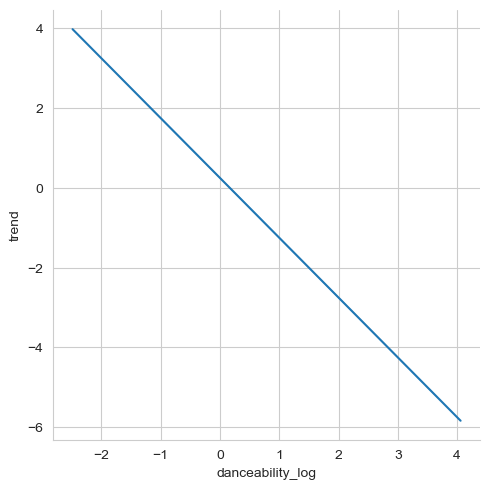

In [118]:
sns.set_style('whitegrid')
sns.relplot(data = final_df, x='danceability_log', y='trend', kind='line')
plt.show()

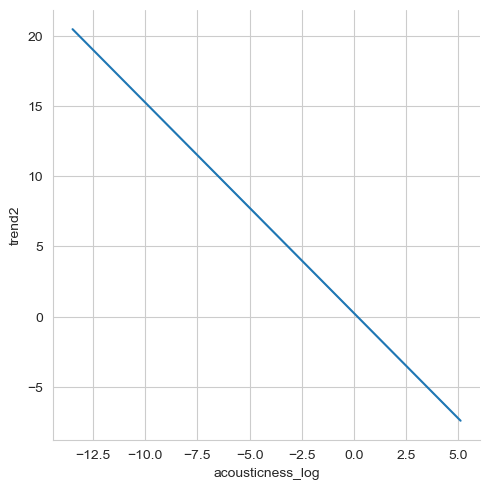

In [121]:
sns.set_style('whitegrid')
sns.relplot(data = final_df, x='acousticness_log', y='trend2', kind='line')
plt.show()

#### Fitting Models

#### No INPUTS! Fit an INTERCEPT-ONLY or CONSTANT AVERAGE model.

In [6]:
mod_intercept_only = smf.ols(formula='y ~ 1', data=final_df).fit()

In [53]:
print(mod_intercept_only.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 11 Dec 2023   Prob (F-statistic):                nan
Time:                        01:56:42   Log-Likelihood:                -62904.
No. Observations:               28356   AIC:                         1.258e+05
Df Residuals:                   28355   BIC:                         1.258e+05
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0330      0.013    -78.201      0.0

In [7]:
mod_intercept_only.params

Intercept   -1.032966
dtype: float64

In [12]:
mod_intercept_only.bse

Intercept    0.013209
dtype: float64

In [13]:
mod_intercept_only.conf_int().\
rename(columns={0: 'ci_lwr', 1: 'ci_upr'})

ci_lwr    ci_upr
Intercept -1.058856 -1.007075

In [100]:
def my_coefplot(mod, figsize_use=(10, 8)):
    fig, ax = plt.subplots(figsize=figsize_use)
    
    ax.errorbar( y=mod.params.index,
                 x=mod.params,
                 xerr = 2 * mod.bse,
                 fmt='o', color='k', ecolor='k', elinewidth=1, ms=3)
    
    ax.axvline(x=0, linestyle='--', linewidth=1.5, color='grey')
    
    ax.set_xlabel('coefficient value')
    
    plt.show()

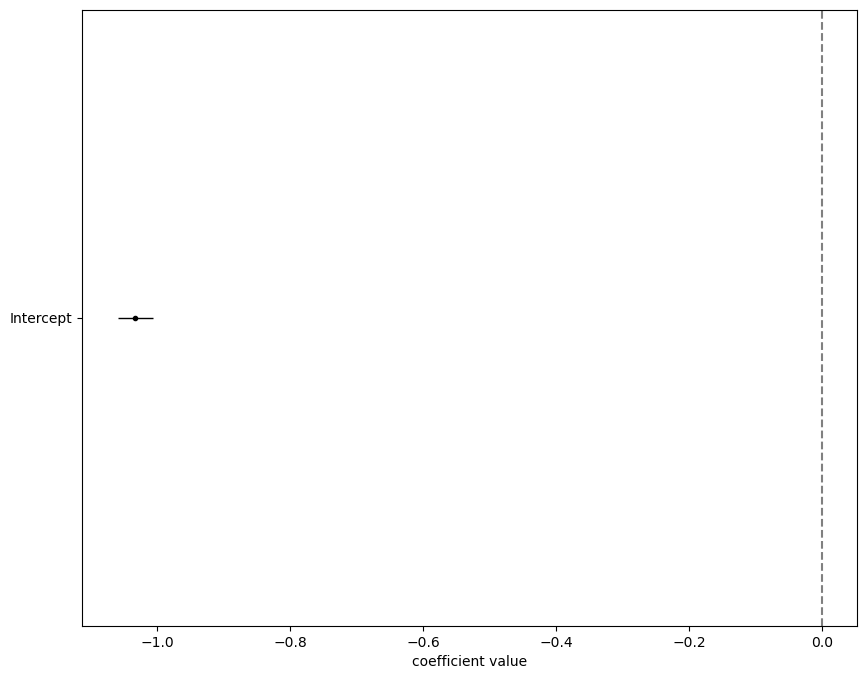

In [101]:
my_coefplot( mod_intercept_only )

#### Categorical inputs with additive features

In [49]:
mod_cat_add = smf.ols(formula='y ~ playlist_genre', data=final_df).fit()

In [54]:
print(mod_cat_add.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     137.5
Date:                Mon, 11 Dec 2023   Prob (F-statistic):          1.30e-144
Time:                        01:56:54   Log-Likelihood:                -62564.
No. Observations:               28356   AIC:                         1.251e+05
Df Residuals:                   28350   BIC:                         1.252e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [55]:
mod_cat_add.params

Intercept                 -1.610313
playlist_genre[T.latin]    0.717071
playlist_genre[T.pop]      1.052043
playlist_genre[T.r&b]      0.325124
playlist_genre[T.rap]      0.756322
playlist_genre[T.rock]     0.570590
dtype: float64

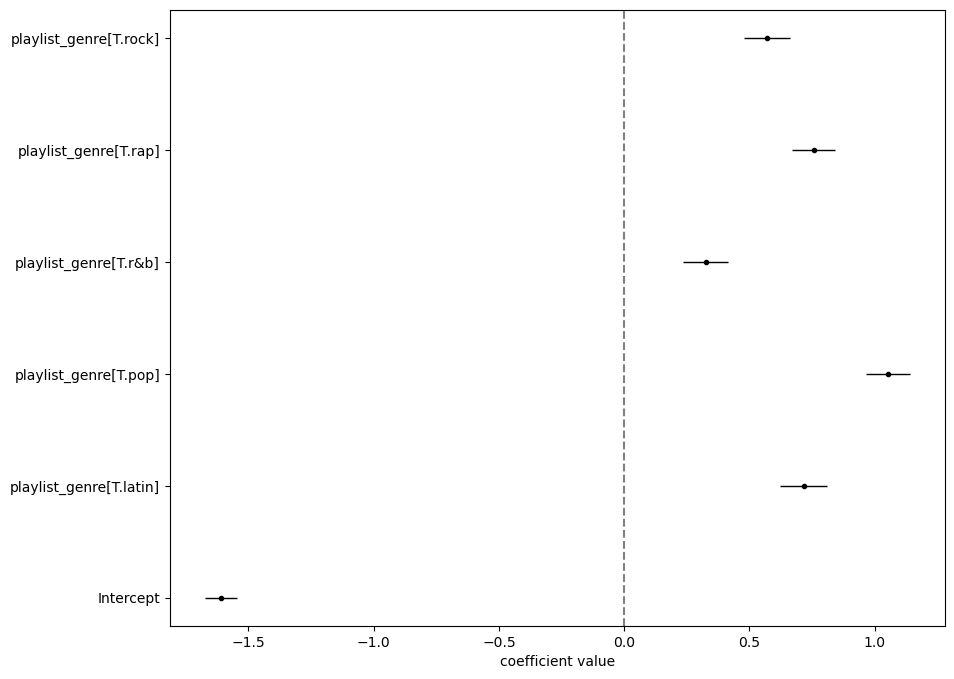

In [102]:
my_coefplot( mod_cat_add )

#### Continuous inputs with linear additive features

In [57]:
final_df.columns

Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'y', 'danceability_log', 'energy_log', 'loudness_log',
       'speechiness_log', 'acousticness_log', 'instrumentalness_log',
       'liveness_log', 'valence_log'],
      dtype='object')

In [59]:
mod_continous_add = smf.ols(formula="y ~ danceability_log + energy_log + loudness_log + speechiness_log + acousticness_log + instrumentalness_log + liveness_log + valence_log", data=final_df).fit()

In [61]:
print(mod_continous_add.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     68.49
Date:                Mon, 11 Dec 2023   Prob (F-statistic):          4.66e-112
Time:                        01:59:23   Log-Likelihood:                -62633.
No. Observations:               28356   AIC:                         1.253e+05
Df Residuals:                   28347   BIC:                         1.254e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.6895 

In [62]:
mod_continous_add.params

Intercept              -1.689519
danceability_log        0.099015
energy_log             -0.113206
loudness_log           -0.028204
speechiness_log        -0.021244
acousticness_log        0.068087
instrumentalness_log   -0.019150
liveness_log           -0.061795
valence_log            -0.027285
dtype: float64

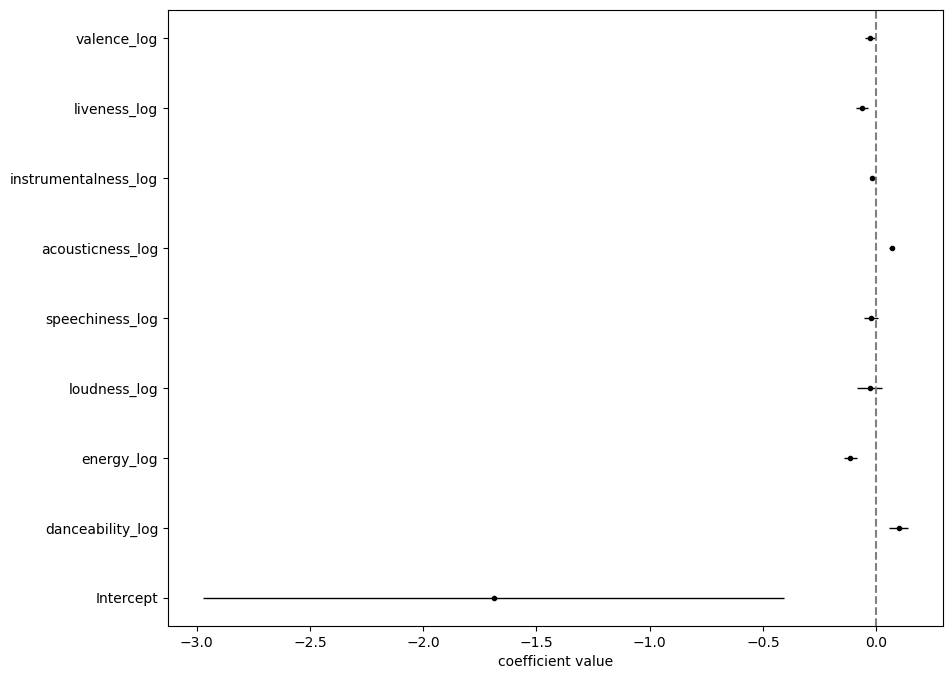

In [103]:
my_coefplot( mod_continous_add )

####  All inputs (continuous and categorical) with linear additive features.

In [57]:
final_df.columns

Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'y', 'danceability_log', 'energy_log', 'loudness_log',
       'speechiness_log', 'acousticness_log', 'instrumentalness_log',
       'liveness_log', 'valence_log'],
      dtype='object')

In [64]:
mod_all_add = smf.ols(formula="y ~ playlist_genre + danceability_log + energy_log + loudness_log + speechiness_log + acousticness_log + instrumentalness_log + liveness_log + valence_log", data=final_df).fit()

In [65]:
print(mod_all_add.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     88.89
Date:                Mon, 11 Dec 2023   Prob (F-statistic):          4.90e-234
Time:                        02:01:49   Log-Likelihood:                -62338.
No. Observations:               28356   AIC:                         1.247e+05
Df Residuals:                   28342   BIC:                         1.248e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [66]:
mod_all_add.params

Intercept                 -2.080923
playlist_genre[T.latin]    0.498435
playlist_genre[T.pop]      0.898821
playlist_genre[T.r&b]      0.025280
playlist_genre[T.rap]      0.491360
playlist_genre[T.rock]     0.619452
danceability_log           0.162616
energy_log                -0.100364
loudness_log              -0.028198
speechiness_log            0.004032
acousticness_log           0.066839
instrumentalness_log      -0.014812
liveness_log              -0.054324
valence_log               -0.065479
dtype: float64

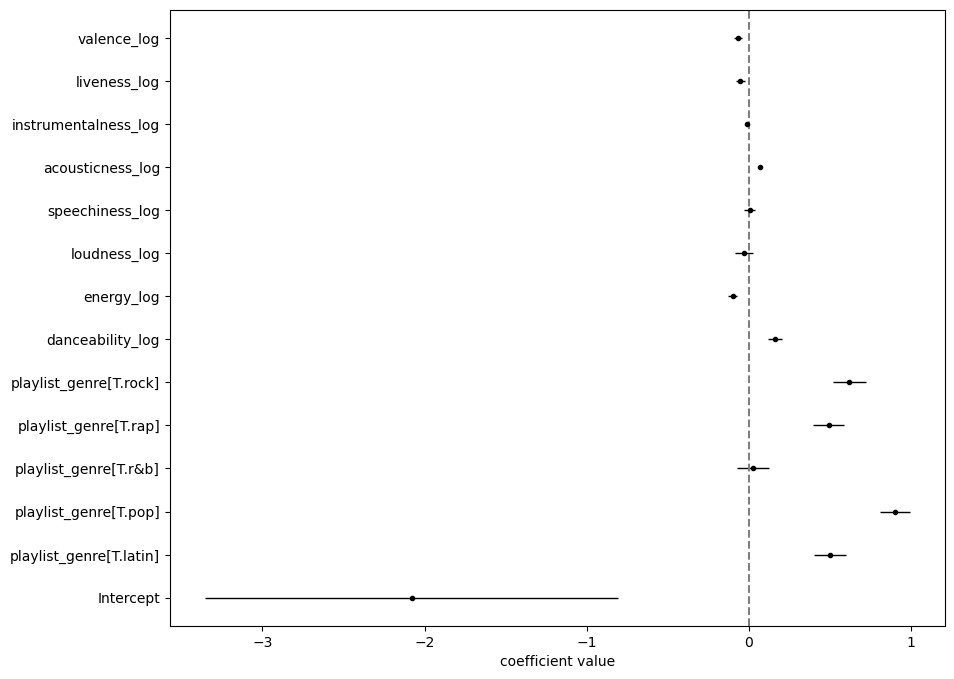

In [104]:
my_coefplot( mod_all_add )

#### Continuous inputs with linear main effect and pair-wise interactions.

In [105]:
mod_main_pair = smf.ols(formula="y ~ (danceability_log + energy_log + loudness_log + speechiness_log + acousticness_log + instrumentalness_log + liveness_log + valence_log) ** 2", data=final_df).fit()

In [106]:
print(mod_main_pair.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     23.33
Date:                Mon, 11 Dec 2023   Prob (F-statistic):          1.50e-142
Time:                        02:23:42   Log-Likelihood:                -62512.
No. Observations:               28356   AIC:                         1.251e+05
Df Residuals:                   28321   BIC:                         1.254e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

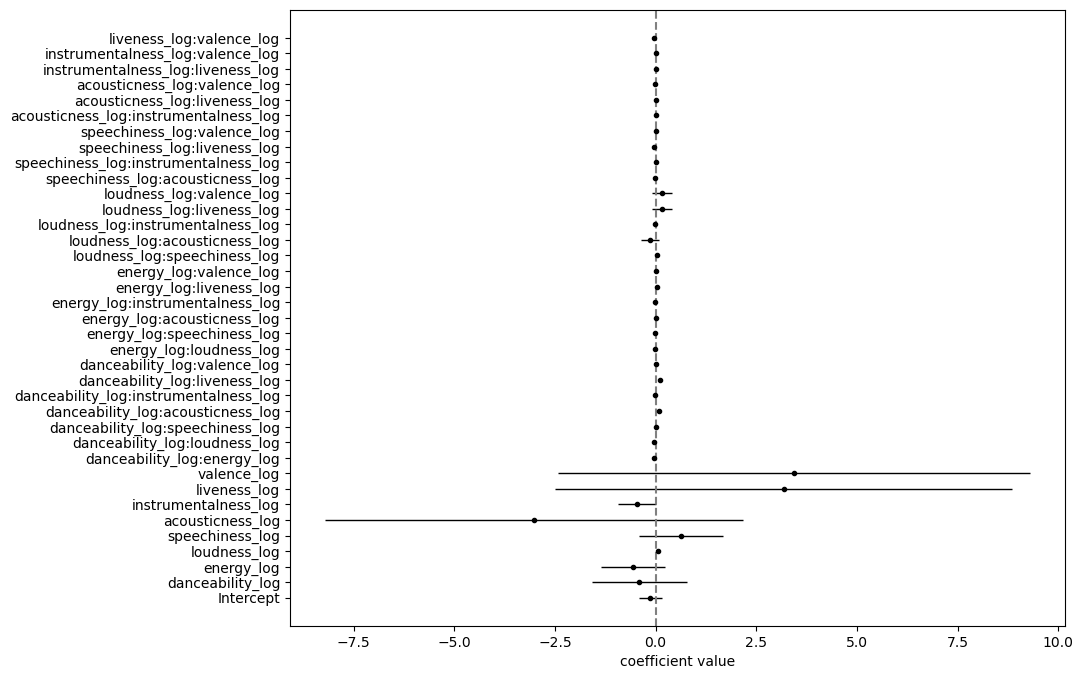

In [107]:
my_coefplot( mod_main_pair )

#### Interact the categorical inputs with the continuous inputs

In [108]:
mod_cat_cont = smf.ols(formula="y ~ (danceability_log + energy_log + loudness_log + speechiness_log + acousticness_log + instrumentalness_log + liveness_log + valence_log) * playlist_genre", data=final_df).fit()

In [109]:
print(mod_main_pair.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     23.33
Date:                Mon, 11 Dec 2023   Prob (F-statistic):          1.50e-142
Time:                        02:25:06   Log-Likelihood:                -62512.
No. Observations:               28356   AIC:                         1.251e+05
Df Residuals:                   28321   BIC:                         1.254e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

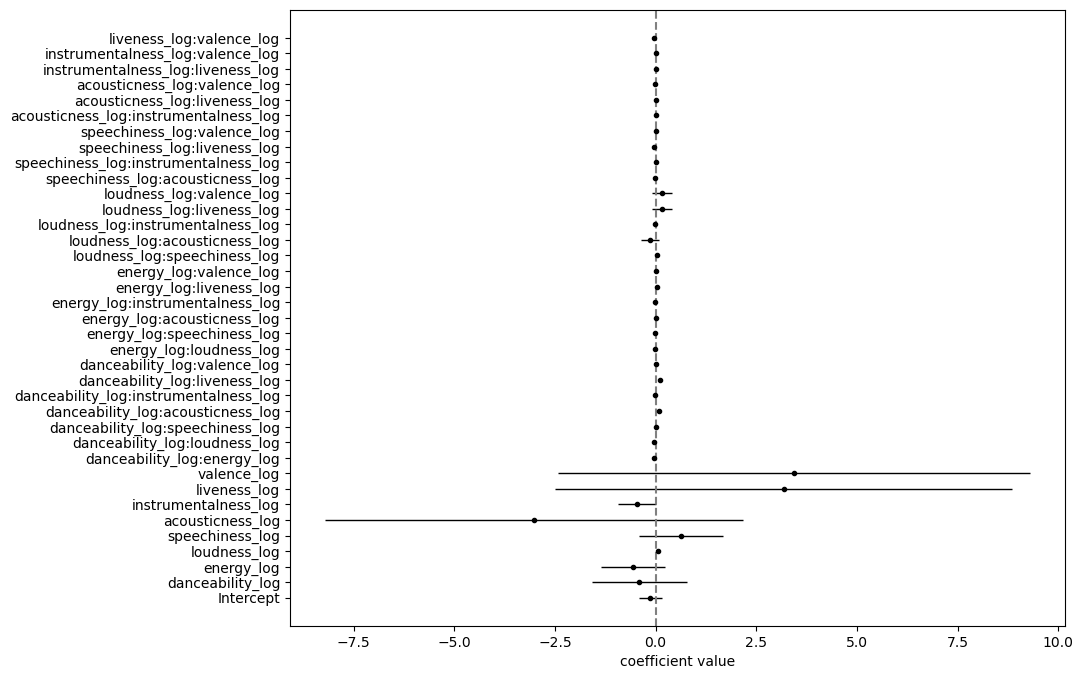

In [110]:
my_coefplot( mod_main_pair )